In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchsampler import ImbalancedDatasetSampler

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
wine_path = './winequality-white.csv'
wine_df = pd.read_csv(wine_path, delimiter=';')
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


<AxesSubplot:xlabel='quality', ylabel='count'>

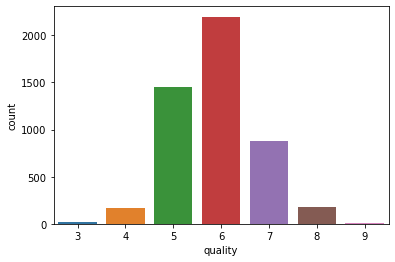

In [23]:
sns.countplot(x = 'quality', data=wine_df)

In [24]:
# Multiclass classification의 target은 [0, n]
# 현재 데이터셋의 target 범위는 [3, 9]
# target 범위 [0, 6]으로 조정하기
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5,
    9:6
}

idx2class = {v:k for k, v in class2idx.items()}

wine_df['quality'].replace(class2idx, inplace=True)

In [25]:
# 마지막 컬럼은 target
X = wine_df.iloc[:, 0:-1]
y = wine_df.iloc[:, -1]

In [26]:
# train, val, test 분리
# 6:2:2
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.25, random_state=42)

In [27]:
# input 정규화
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train))
X_val_scaled = torch.tensor(scaler.transform(X_val))
X_test_scaled = torch.tensor(scaler.transform(X_test))

In [28]:
y_train = torch.tensor(np.array(y_train))
y_val = torch.tensor(np.array(y_val))
y_test = torch.tensor(np.array(y_test))

In [29]:
# target의 class별 데이터분포 계산
def get_class_distribution(obj):
    count_dict = {
        '3': 0,
        '4': 0,
        '5': 0,
        '6': 0,
        '7': 0,
        '8': 0,
        '9': 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['3'] += 1
        elif i == 1: 
            count_dict['4'] += 1
        elif i == 2: 
            count_dict['5'] += 1
        elif i == 3: 
            count_dict['6'] += 1
        elif i == 4: 
            count_dict['7'] += 1  
        elif i == 5: 
            count_dict['8'] += 1              
        elif i == 6: 
            count_dict['9'] += 1              
        else:
            print('oops...')
            
    return count_dict

In [30]:
# pytorch Dataset 만들기
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_dataset = CustomDataset(X_train_scaled.float(), y_train.long())
val_dataset = CustomDataset(X_val_scaled.float(), y_val.long())
test_dataset = CustomDataset(X_test_scaled.float(), y_test.long())

In [31]:
# 오버샘플링에 사용할 sampler 만들기
# val, test는 모델 평가용 set이므로 오버샘플링 안해도 됨
target_list = torch.tensor([target for target in train_dataset.y_data])

In [32]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1.0 / torch.tensor(class_count, dtype=torch.float)
class_weights_all = class_weights[target_list]

In [33]:
# WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True)

In [34]:
# 모델 하이퍼파라미터
EPOCHS = 4000
BATCH_SIZE = 512
LEARNING_RATE = 0.0017

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 7

In [35]:
# pytorch DataLoader
# 오버샘플링 한 train_loader
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
# 오버샘플링 안한 train_loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [36]:
# pytorch model
class MulticlassClassification(nn.Module):
    def __init__(self, num_features, num_classes):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_classes) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.4)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        return x

In [37]:
# nvidia cuda 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [38]:
# 모델 생성
model = MulticlassClassification(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

model.to(device)

# multiclass classification loss
# softmax 포함됨
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# optimizer adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# learning rate decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

In [39]:
# 예측 정확도 계산 함수
def multi_accuracy(y_pred, y_target):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
    
    correct_pred = (y_pred_tags == y_target).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    
    accuracy *= 100.0
    
    return accuracy

In [40]:
for epoch in tqdm(range(1, EPOCHS + 1)):
    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_accuracy = multi_accuracy(y_train_pred, y_train_batch)
        
        for param in model.parameters():
            param.grad = None
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_accuracy += train_accuracy.item()
        
        
    scheduler.step()
        
    with torch.no_grad():
        val_epoch_loss = 0.0
        val_epoch_accuracy = 0.0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_accuracy = multi_accuracy(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_accuracy += val_accuracy.item()
            
    mean_train_accuracy = train_epoch_accuracy / len(train_loader)
    mean_val_accuracy = val_epoch_accuracy / len(val_loader)
    mean_train_loss = train_epoch_loss / len(train_loader)
    mean_val_loss = val_epoch_loss / len(val_loader)
    
    if epoch < 4 or epoch % 500 == 0:
        print(f'Epoch {epoch+0:04}: | Train Loss: {mean_train_loss:.4f} | Val Loss: {mean_val_loss:.4f} | Train Acc: {mean_train_accuracy:.2f}| Val Acc: {mean_val_accuracy:.2f}')

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0001: | Train Loss: 2.0001 | Val Loss: 1.8345 | Train Acc: 12.47| Val Acc: 31.60
Epoch 0002: | Train Loss: 1.6699 | Val Loss: 1.6877 | Train Acc: 23.81| Val Acc: 29.18
Epoch 0003: | Train Loss: 1.5653 | Val Loss: 1.5712 | Train Acc: 27.82| Val Acc: 24.66
Epoch 0500: | Train Loss: 0.0878 | Val Loss: 5.1492 | Train Acc: 92.46| Val Acc: 60.29
Epoch 1000: | Train Loss: 0.0184 | Val Loss: 6.9619 | Train Acc: 98.33| Val Acc: 61.00
Epoch 1500: | Train Loss: 0.0080 | Val Loss: 8.4741 | Train Acc: 99.51| Val Acc: 62.00
Epoch 2000: | Train Loss: 0.0054 | Val Loss: 8.8481 | Train Acc: 99.57| Val Acc: 62.52
Epoch 2500: | Train Loss: 0.0051 | Val Loss: 9.4246 | Train Acc: 99.53| Val Acc: 62.03
Epoch 3000: | Train Loss: 0.0023 | Val Loss: 9.7662 | Train Acc: 99.84| Val Acc: 62.37
Epoch 3500: | Train Loss: 0.0029 | Val Loss: 9.8676 | Train Acc: 99.74| Val Acc: 61.93
Epoch 4000: | Train Loss: 0.0022 | Val Loss: 10.0719 | Train Acc: 99.84| Val Acc: 61.83


In [41]:
# test model
y_test_pred_list = []

with torch.no_grad():
    model.eval()
    for X_test_batch, _ in test_loader:
        X_test_batch = X_test_batch.to(device)
        y_test_pred = model(X_test_batch)
        y_test_pred_softmax = torch.log_softmax(y_test_pred, dim=1)
        _, y_test_pred_tags = torch.max(y_test_pred_softmax, dim = 1)
        y_test_pred_list.append(y_test_pred_tags.cpu().numpy())
        
y_test_pred_list = [a.squeeze().tolist() for a in y_test_pred_list]

Text(33.0, 0.5, 'Real')

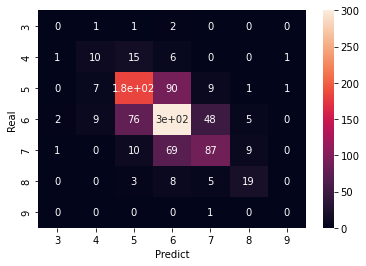

In [42]:
# test 결과 시각화
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred_list)).rename(columns=idx2class, index=idx2class)

ax = plt.subplot()

sns.heatmap(confusion_matrix_df, annot=True)

ax.set_xlabel('Predict')
ax.set_ylabel('Real')

In [43]:
# test 정확도 계산
correct_pred = (y_test == torch.tensor(y_test_pred_list))

accuracy = correct_pred.sum() / len(correct_pred)

accuracy *= 100.0

print('Test accuracy: ', accuracy)

Test accuracy:  tensor(61.1224)
